### The following jupyter notebook represents most of the code used to create a method for finding gas vesicles gene clusters.

The code below will find all the refseqs corresponding to a given list of species. The user can specify whether only fully assembled genome refseqs should be acquired or also contig level refseqs and scaffolds should be included. As text inputs, the literature verified gas vesicle species list and pfam list was used, so that most of the possible gas vesicle producers are incorporated into the local database.

In [ ]:
#!/usr/bin/env python3
"""
Author: Matthijs Smits 950103779040
argv[1]=list of species or taxids in text format
argv[2]=name of output file where refseqs will be stored
"""
from sys import argv
import os
import time
from urllib.request import urlopen
from Bio import Entrez
Entrez.email = "matthijs.smits@wur.nl"    
                
def refseq_writer(best_refseqs,species,assembly_type):
    """
    Prints all refseq info to terminal.
    
    best_refseqs:list of refseqs (strings) that were found by 
    function 'refseq retriever'
    species: Scientific species name (string)
    assembly_type:'complete','scaffold','contig'(string)
    """
    print('Largest assembly for species %s was found \
    to be %d refseqs long and is @ level: %s' %(species,len(best_refseqs),
    assembly_type))
    print('Assembly consists of refseqs:')
    print(best_refseqs)
    with open(argv[2],'a') as refseqs_list:
        for refseq in best_refseqs:
            refseqs_list.write('%s\n'%(refseq))
    print('Stored refseqs succesfully')
    return None

def refseq_retriever (species,ID_list,include_scaffold,include_contig):
    """
    Acquires one or more refseqs of records belonging to a list of IDs.
    
    
    ID_list: list of IDs (strings)
    include_scaffold: boolean value
    include_contig: boolean value
    """
    max_refseqs=0
    best_refseqs=[]
    for ID in ID_list:
        esummary_handle = Entrez.esummary(db="assembly", id=ID, retmode="xml",report='full')
        esummary_record = Entrez.read(esummary_handle)
        link = esummary_record['DocumentSummarySet']['DocumentSummary'][0]['FtpPath_Assembly_rpt']
        list_of_refseqs=assembly_report_parser_complete(link)
        if len(list_of_refseqs)>max_refseqs:
                best_refseqs=list_of_refseqs
                assembly_type='complete'
                max_refseqs=len(list_of_refseqs)
    if len(best_refseqs)==0 and include_scaffold:
        for ID in ID_list:
            esummary_handle = Entrez.esummary(db="assembly", id=ID, retmode="xml",report='full')
            esummary_record = Entrez.read(esummary_handle)
            link = esummary_record['DocumentSummarySet']['DocumentSummary'][0]['FtpPath_Assembly_rpt']
            list_of_refseqs=assembly_report_parser_scaffold(link)
            if len(list_of_refseqs)>max_refseqs:
                best_refseqs=list_of_refseqs
                assembly_type='scaffold'
                max_refseqs=len(list_of_refseqs)
    if len(best_refseqs)==0 and include_contig:
        for ID in ID_list:
            esummary_handle = Entrez.esummary(db="assembly", id=ID, retmode="xml",report='full')
            esummary_record = Entrez.read(esummary_handle)
            link = esummary_record['DocumentSummarySet']['DocumentSummary'][0]['FtpPath_Assembly_rpt']
            list_of_refseqs=assembly_report_parser_contig(link)
            if len(list_of_refseqs)>max_refseqs:
                best_refseqs=list_of_refseqs
                assembly_type='contig'
                max_refseqs=len(list_of_refseqs)
    if best_refseqs!=[]:
        refseq_writer(best_refseqs,species,assembly_type)
    else:
        print ('Assemblies were found to be inadequate')
        return None
    return None
        
def ID_retriever(species,include_scaffold,include_contig):
    """
    Acquires accession number using Entrez based on scientific species name.
    
    species: scientific name of species, string.
    include_scaffold: boolean value
    include_contig: boolean value
    """
    search_term='%s[orgn]'%(species)
    handle = Entrez.esearch(db="assembly", term=search_term, idtype="acc")
    record = Entrez.read(handle)
    ID_list=record["IdList"]
    if len(ID_list)==0:
        print('No assemblies were found for species %s'%(species))
        return None
    print('Found %d assemblies for species %s'%(len(ID_list), species))
    refseq_retriever(species,ID_list,include_scaffold,include_contig)
    return None

def assembly_report_parser_complete(link):
    """
    Opens complete level assembly report of any given link and parses out 
    refseqs.
    
    link: String of url link to assembly report.
    Returns: List of refseq strings.
    """
    list_of_refseqs=[]
    assembly_report_handle = urlopen(link)
    assembly_report = assembly_report_handle.read().decode('utf-8')
    if '# Assembly level: Complete Genome' in assembly_report:
        complete_genome_found=True
        last_lines=assembly_report.split('# Sequence-Name')[1].split('\n')[1:]
        for line in last_lines:
            if '\t=\t' in line:
                refseq=line.split('\t=\t')[1].split('\t')[0]
                list_of_refseqs.append(refseq)
            if '\t<>\t' in line:
                refseq=line.split('\t<>\t')[0].split('\t')[-1]
                list_of_refseqs.append(refseq)
    return list_of_refseqs

def assembly_report_parser_scaffold(link):
    """
    Opens scaffold level assembly report of any given link and parses out 
    refseqs.
    
    link: String of url link to assembly report.
    Returns: List of refseq strings.
    """
    list_of_refseqs=[]
    assembly_report_handle = urlopen(link)
    assembly_report = assembly_report_handle.read().decode('utf-8')
    if '# Assembly level: Scaffold' in assembly_report:
        complete_genome_found=True
        last_lines=assembly_report.split('# Sequence-Name')[1].split('\n')[1:]
        for line in last_lines:
            if '\t=\t' in line:
                refseq=line.split('\t=\t')[1].split('\t')[0]
                list_of_refseqs.append(refseq)
            if '\t<>\t' in line:
                refseq=line.split('\t<>\t')[0].split('\t')[-1]
                list_of_refseqs.append(refseq)
    return list_of_refseqs

def assembly_report_parser_contig(link):
    """
    Opens contig level assembly report of any given link and parses out 
    refseqs.
    
    link: String of url link to assembly report.
    Returns: List of refseq strings.
    """
    list_of_refseqs=[]
    assembly_report_handle = urlopen(link)
    assembly_report = assembly_report_handle.read().decode('utf-8')
    if '# Assembly level: Contig' in assembly_report:
        complete_genome_found=True
        last_lines=assembly_report.split('# Sequence-Name')[1].split('\n')[1:]
        for line in last_lines:
            if '\t=\t' in line:
                refseq=line.split('\t=\t')[1].split('\t')[0]
                list_of_refseqs.append(refseq)
            if '\t<>\t' in line:
                refseq=line.split('\t<>\t')[0].split('\t')[-1]
                list_of_refseqs.append(refseq)
    return list_of_refseqs
    
def taxid_to_species(taxid,include_scaffold,include_contig):
    """ 
    Converts a given taxid number to a scientific species name.
    
    taxid: string
    include_scaffold: boolean value
    include_contig: boolean value
    Returns: None
    """
    search_term='%s[uid]'%(taxid)
    handle = Entrez.esearch(db="taxonomy", term=search_term)
    record = Entrez.read(handle)
    ID=record["IdList"][0]
    esummary_handle = Entrez.esummary(db="taxonomy", id=ID, retmode="xml",report='full')
    esummary_record = Entrez.read(esummary_handle)
    scientific_name=esummary_record[0]['ScientificName']
    print('Taxid %s converted to scientific name %s'%(taxid.strip(),scientific_name))
    time.sleep(30)
    ID_retriever(scientific_name,include_scaffold)
    
    
def main():
    """
    Main controller function which decides which functions to run based
    on user input.
    
    Returns: None
    """
    include_scaffold=False
    include_contig=False
    incorrect_input=True
    while incorrect_input:
        userinput1=input('Press S for species, press T for taxids')
        userinput2=input('Press A for complete assemblies only, press '+\
        'S to also incorporate scaffold level assemblies or press C to '+\
        'also incorporate contig level assemblies.')
        if userinput2=='S':
            include_scaffold=True
        if userinput2=='C':
            include_scaffold=True
            include_contig=True
        if userinput1=='S':
            with open(argv[1],'r') as species_list:
                all_species=species_list.readlines()
                for species in all_species:
                    ID_retriever(species.strip(),include_scaffold,include_contig)
                    
            incorrect_input=False
            
        elif userinput2=='T':
            with open(argv[1],'r') as taxid_list:
                taxids=taxid_list.readlines()
                for taxid in taxids:
                    taxid_to_species(taxid.strip(),include_scaffold,include_contig)
            incorrect_input=False
            
        else:
            print('Wrong input')

    

if __name__ == '__main__':
    main()

    


From the list of refseqs, the genomes can be downloaded in genbank format with the code below. The loop is put to sleep for a minute on each iteration so that the server requests stay within limits.

In [ ]:
#!/usr/bin/env python3
"""
Author: Matthijs Smits 950103779040
argv[1]=location of text file in which list of refseqs in stored
argv[2]=output directory where genbank genomes will be placed
"""
from sys import argv
import os
import time
list_of_refseqs = open(argv[1]).readlines()
output_directory=argv[2]
from Bio import Entrez
Entrez.email = "matthijs.smits@wur.nl"    
 

def genome_downloader (accession):
    """
    Uses entrez in order to download a given genbank genome 
    corresponding to a refseq string.
    
    accession: refseq ID string
    Returns: None
    """
    output_string='%s/%s.gbk'%(output_directory,accession.strip())
    print(output_string)
    if not os.path.exists(output_string):
        handle = Entrez.efetch(db="nucleotide", id=accession, rettype="gbwithparts", retmode="text")
        record_string=handle.read()
        with open(output_string, 'w') as record_writer:
            record_writer.write(record_string)
        print('Download of %s succesful'%(accession.strip()))
        time.sleep(60)
        
    return None
    

if __name__ == '__main__':
    for accession in list_of_refseqs:
        genome_downloader(accession)
        


In this step, Multigeneblast is run (code not shown) on all the downloaded genomes. The search query for multigeneblast is a fasta sequence made by compiling all literature verified clusters from 6 different phyla into one. See image below. A database was generated from over 500 input GenBank genomes/plasmids using the tool MakeDB, which is required in order to run Multigeneblast. An architectural Multigeneblast run was performed by using a minimum sequence coverage of 30\%, a minimum percent identity of 40\% and a maximum distance between two blast hits (to be counted as belonging to the same locus) of 10kb. Multigeneblast creates an output region with all significant blast hits in it and also includes flanking regions of 20 kb on each side of the outer two blast hits. The Multigeneblast output was processed using a custom script by parsing the output file and referring back to the original GenBank files to extract all protein sequences found within the region.

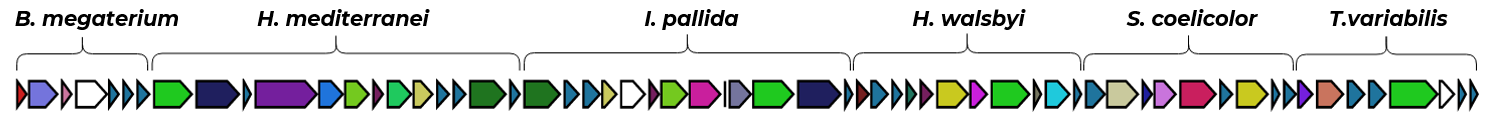

In [8]:
from IPython.display import Image
Image(filename='/home/smits083/data/multigeneblast/Picture2.png' )

## Parsing multigeneblast output

Below, the code for parsing the proteins from the initial genbank files is given. It parses the output from multigeneblast, acquired the positions and genbank filenames from it, and uses it to look througout the folder containing all genomes, and acquires all proteins from it. A fasta file is generated with the following format:

>prot_id1|chromosome|organism|product|start|stop|sense
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
>prot_id2|chromosome|organism|product|start|stop|sense
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA

>etc

In [ ]:
#!/usr/bin/env python3
"""
Author: Matthijs Smits 950103779040
argv[1]=Path to multigeneblast output file.
argv[2]=Path to directory containing original genbank files.
"""

from sys import argv
import os
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import SeqFeature, FeatureLocation
from Bio import SeqIO

protein_data_list=[]


def multigene_parser(filepath=argv[1]):
    """
    Generator function that opens multigeneblast 
    output file and splits it and acquires
    specific lines from each entry.
    
    filepath: path to multigeneblast output file 
    (default=argv[1])
    Returns: None, generator function.
    """
    in_handle = open(filepath, 'r')
    input_file=in_handle.read()
    for record in input_file.split('>>')[1:]:
        info=record.split('\n\n')[1].split('\n')[0].split()[1]
        location_1=record.split('\n\n')[3].split('\n')[1].split()[1]
        location_2=record.split('\n\n')[3].split('\n')[-1].split()[2]
        yield(info,location_1,location_2)
        
def record_maker(filepath):
    """
    Uses seqIO from biopython in order to parse
    a given genbank file.
    
    filepath=Path referring genbank file
    Returns=None, generator function
    """
    in_handle = open(filepath, 'r')
    for record in SeqIO.parse(in_handle, "genbank"):
        yield(record)
        
def record_parser(generator_func,start_cluster,stop_cluster):
    """
    Creates a list of tuples representing the cluster in a
    given genome/genbank files.
    
    generator_func=Generator function which provides genbank records
    start_cluster=start position of first gene in cluster
    stop_cluster=stop position of last gene in clusters
    Returns: None (appends to global list)
    """
    for rec in generator_func:
        previous_stop=0
        chromosome=rec.id
        organism=rec.annotations['organism'].split()
        organism='_'.join(organism)
        topology=rec.annotations['topology']
        sequence=rec.seq
        feats = [feat for feat in rec.features if feat.type == "CDS"]
        for feat in feats:
            location_str=str(feat.location)
            start=int(''.join(i for i in (location_str.split(':')[0]) if i.isdigit()))
            stop=int(''.join(i for i in (location_str.split(':')[1]) if i.isdigit()))
            if start_cluster<=start and stop_cluster>=stop:
                product=str(feat.qualifiers.get('product', "None"))
                if '+' in location_str:
                    sense='+'
                else:
                    sense='-'
                prot_seq=feat.qualifiers.get('translation', "None")[0]
                product=feat.qualifiers.get('product', "None")[0].split()
                product='_'.join(product)
                prot_id=feat.qualifiers.get('protein_id', "None")[0]
                protein_data_tuple=(prot_id,chromosome,organism,product,start,stop,sense,prot_seq)
                previous_stop=stop
                print(protein_data_tuple)
                protein_data_list.append(protein_data_tuple)

def cluster_slicer (gbk_location=argv[2]):
    """
    Uses info from multigeneblast output to
    determine genbank path and start/stop coordinates of
    cluster.
    
    gbk_location: Path to gbk directory
    Returns: None
    """
    for info,loc_1,loc_2 in multigene_parser():
        target_file = [filename for filename in os.listdir(gbk_location)
        if filename.startswith(info[:-2])][0]
        genbank_string='%s/%s'%(gbk_location,target_file)
        record_parser(record_maker(genbank_string),int(loc_1),int(loc_2))
        
def fasta_output (protein_data_list):
    """
    Writes all proteins in all clusters to a fasta file. 
    Puts additional info in fasta headers.
    
    protein_data_list: List of tuple representing clusters.
    """
    with open(argv[3], 'w') as fasta_output:
        for protein_data_tuple in protein_data_list:
            fasta_output.write('>%s|%s|%s|%s|%s|%s|%s\n%s\n'%(protein_data_tuple[0],
            protein_data_tuple[1],protein_data_tuple[2],protein_data_tuple[3],
            protein_data_tuple[4],protein_data_tuple[5],protein_data_tuple[6],
            protein_data_tuple[7]))
            
if __name__ == '__main__':
    cluster_slicer()
    fasta_output(protein_data_list)
    


In this step, all the proteins from the previous script are clustered using MMSEQS2 (code not shown). A similarity treshold of 0.5 was applied.

The various clusters have different properties in terms of size, genus distribution, and more. We need to select clusters that are promising in terms of their relatedness to gas vesicle production. Hence, below, the clusters are parsed out and then assesed for their size (there should be at least 3 seqs in a cluster), species (there should be 5 unique species), 

In [ ]:
#!/usr/bin/env python3
"""
Author: Matthijs Smits 950103779040
Arguments:
1 - Mmseqs2 fasta output
2 - textual list of verified species
3 - Output directory for fasta files 

Further processing:
Alignment - for i in *;do clustalw "$i";done
Hmm creation - for i in *;do hmmbuild "$i.hmm" "$i";done
for file in *.; do mv -- "$file" "$(basename -- "$file" .).hmm";done
"""
from sys import argv

list_of_mmseq_entries = open(argv[1]).readlines()



def cluster_splitter(list_of_entries):
    """
    Opens a fasta file list containing all clusters, separates
    the clusters based on encountering two headers.
    
    list_of_entries: list of strings representing all lines in MMSEQS output
    """
    start_of_cluster=0
    cluster_list=[]
    for index,entry in enumerate (list_of_entries):
        if entry.strip()==list_of_entries[index-1].strip(): # MMSEQS output starts a cluster when two of the same headers occur twice after eachother
            sub_list=list_of_entries[start_of_cluster:index-1]
            start_of_cluster=index-1
            cluster_list.append(sub_list)
            
    return cluster_list
    
def remove_singletons(cluster_list):
    """
    Removes clusters with less than 3 entries.
    
    cluster_list: list of lists, each list is one cluster.
    """
    clean_cluster_list=[]
    for index,cluster in enumerate(cluster_list):
        if not len(cluster)==3:
            clean_cluster_list.append(cluster_list[index])
    return cluster_list_1
    
def remove_non_gvp(cluster_list_1):
    """
    Removes clusters that either do not have any keywords 
    in their gene's annotations, or that are smaller 
    than 10 proteins. 
    
    cluster_list_1: list of lists, each list is one cluster.
    """
    cluster_list_2=[]
    for index,cluster in enumerate(cluster_list_1): #selecting clusters that have at least one occurence of a key word in them
        count=0
        if any("gas " in s for s in cluster)\
        or any("Gvp" in s for s in cluster)\ 
        or any("vesicle" in s for s in cluster)\
        or any("gas_)" in s for s in cluster):
            cluster_list_2.append(cluster_list_1[index])
        
        elif len(cluster)>=10: #clusters that consist of more than 30 proteins will be included even if they don't contain the keywords
            cluster_list_2.append(cluster_list_1[index])

    return cluster_list_2
            
def species_verifier (cluster_list_2):
    """
    Removes clusters that have 0 proteins in their cluster from
    verified species.
    
    cluster_list_2: list of lists, each list is one cluster.
    """
    verified_species = open(argv[3]).read().split('\n')
    cluster_list_3=[]
    for cluster in cluster_list_2:
        print(len(cluster))
        species_in_cluster=[]
        verified_cluster=False
        for entry in cluster:
            if '|' in entry:
                species= entry.split('|')[2].replace('_',' ')
                species_in_cluster.append(species)
        print(len(species_in_cluster))
        for species in verified_species:
            if any(species in s for s in species_in_cluster):
                verified_cluster=True
        if verified_cluster==True:
            cluster_list_3.append(cluster)
    return cluster_list_3

def cluster_diversity (cluster_list_3): 
    """
    Removes clusters that do not have 5 unique species in it.
    
    cluster_list_3: list of lists, each list is one cluster.
    """
    cluster_list_4=[]
    for cluster in cluster_list_3:
        species_in_cluster=[]
        for entry in cluster:
            if '|' in entry:
                species= entry.split('|')[2].replace('_',' ')
                species_in_cluster.append(species)
        if len(species_in_cluster)>=5:
            cluster_list_4.append(cluster)
    return cluster_list_4
    
def fasta_writer(clean_cluster_list):
    """
    Writes all clusters to a fasta file. 
    
    clean_cluster_list: list of lists, each list is one cluster.
    """
    output_directory=argv[2]
    for index,cluster in enumerate(verified_cluster_list):
        with open('%s/cluster%s.fasta'%(output_directory, index), 'w') as fasta_output:
            for entry in cluster[1:]:
                fasta_output.write('%s\n'%(entry.strip()))
        print('Wrote cluster %s succesfully' % (index))
    return None
        
            
                
if __name__ == '__main__':
    cluster_list=cluster_splitter(list_of_mmseq_entries)
    print(len(cluster_list))
    cluster_list_1=remove_singletons(cluster_list)
    print(len(cluster_list_1))
    cluster_list_2=remove_non_gvp(cluster_list_1)
    print(len(cluster_list_2))
    cluster_list_3=species_verifier(cluster_list_2)
    print(len(cluster_list_3))
    clean_cluster_list=cluster_diversity(cluster_list_3)
    print(len(clean_cluster_list)
    fasta_writer(clean_cluster_list)
            
        


After acquiring all the separate proteins from the clusters (right after discarding irrelevant clusters), a few important steps are taken, of which the code is not shown here. The steps are the following:

-The proteins are all subjected to the EFI-EST pipeline. This allows for a visual inspection of the protein sequence similarity network in Cytoscape. Cytoscape is then used to manually pick the appropriate groups for further processing.

-The protein groups from cytoscape are then turned into fasta files of at least 30+ sequences, and subsequently used for the creation of an HMM model. 

-All HMM models are combined, including those that were already publicly available on Pfam. Antismash is modified with the use of the HMM models. The following is done:
    1.All original antismash rules are deleted (for cluster detection but not for secondary metabolite detection)
    2.A new rule is added that asserts whether two of any of the HMM models discussed previously occur within close        proximity of eachother. The rule is named 'GAS_VESICLE'.
    
    
Modified Antismash was run on all initially acquired genomes from step one. Then, the regions that are detected by antismash are trimmed with the code below. This is done because antismash automatically takes a region of at least 20 genes on each side of a given HMM hit, thereby the actual 'core cluster/operon' is likely to be smaller. The trimming of these regions is based on HMM hits, sense, annotations and the length of intergenic regions. 

In [26]:
#!/usr/bin/env python3
"""
Author: Matthijs Smits 950103779040
Arguments:

Takes an antismash output genbank file and distills it to its clusters, outputs the new, shortened genbank file.
It bases the slicing on annotations,distances between genes, and sense of the gene.

"""

import os
import json
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import SeqFeature, FeatureLocation
from Bio import SeqIO


def record_maker(filepath):
    """
    Creates parsed records from a genbank file. 
    
    filepath: String referring to gbk file location.
    """
    in_handle = open(filepath, 'r')
    for record in SeqIO.parse(in_handle, "genbank"):
        yield(record)
        
        
def record_parser(generator_func):
    """
    Creates a list of tuples, representing each protein and its features,
    including HMM hit information.
    
    generator_func: biopython parser 
    """
    protein_data_list=[]
    for rec in generator_func:
        previous_stop=0
        chromosome=rec.id
        organism=rec.annotations['organism'].split()
        organism='_'.join(organism)
        topology=rec.annotations['topology']
        sequence=rec.seq
        
        feats = [feat for feat in rec.features if feat.type == "CDS"]
        for feat in feats:
            location_str=str(feat.location)
            start=int(''.join(i for i in (location_str.split(':')[0]) if i.isdigit()))
            stop=int(''.join(i for i in (location_str.split(':')[1]) if i.isdigit()))
            product=str(feat.qualifiers.get('product', "None"))
            if '+' in location_str:
                sense='+'
            else:
                sense='-'
            prot_seq=feat.qualifiers.get('translation', "None")[0]
            product=feat.qualifiers.get('product', "None")[0].split()
            hmm_hit=('_'.join(feat.qualifiers.get('gene_functions','None')[0].split()))
            if 'GAS_VESICLE' in hmm_hit:
                hmm_hit=hmm_hit.split(':')[1][1:]
            else:
                hmm_hit='No HMM hit'
            product='_'.join(product)
            prot_id=feat.qualifiers.get('protein_id', "None")[0]
            protein_data_tuple=(prot_id,chromosome,organism,product,hmm_hit,start,stop,sense,prot_seq)
            protein_data_list.append(protein_data_tuple)
    return protein_data_list
                

def find_outer_two(protein_data_list):
    """
    Determines the outer two HMM hits of a gvGC. 
    
    protein_data_list: list of tuples representing all proteins 
    """
    for prot_tuple in protein_data_list:
        if 'GVP' in prot_tuple[4] or 'Gvp' in prot_tuple[4]:
            first_hit=prot_tuple
            break
    protein_data_list.reverse()
    for prot_tuple in protein_data_list:
        if 'GVP' in prot_tuple[4] or 'Gvp' in prot_tuple[4]:
            last_hit=prot_tuple
            break
    protein_data_list.reverse()
    return(first_hit,last_hit)
            
def boundary_defining(protein_data_list,first_hit,last_hit):
    """
    Uses specific criteria to work outwards from the outer two HMM hits. 
    
    protein_data_list:list of tuples representing all proteins 
    first_hit:tuple found to be the first hit
    last_hit:tuple found to be the last hit
    """
    gas_vesicle_terms=['gas ','Gvp','vesicle','gas_'] 
    found=False
    true_first_hit=None
    true_last_hit=None
    for prot_tuple in protein_data_list:
        if last_hit==prot_tuple:
            found=True
            previous_tuple=prot_tuple
            continue
        if found:
            if (abs((prot_tuple[5]-previous_tuple[6]))<200 and \
                prot_tuple[7]==previous_tuple[7]) or \
                any(term in prot_tuple[3] for term in gas_vesicle_terms):
                true_last_hit=prot_tuple
                previous_tuple=prot_tuple
            else:
                break
    protein_data_list.reverse()
    found=False
    for prot_tuple in protein_data_list:
        if first_hit==prot_tuple:
            found=True
            previous_tuple=prot_tuple
            continue
        if found:
            if (abs((previous_tuple[5]-prot_tuple[6]))<200 and \
                prot_tuple[7]==previous_tuple[7]) or \
                any(term in prot_tuple[3] for term in gas_vesicle_terms):
                true_first_hit=prot_tuple
                previous_tuple=prot_tuple
            else:
                break
    protein_data_list.reverse()
    if true_last_hit!=None and true_first_hit!=None:
        return(true_first_hit,true_last_hit)
    if true_last_hit!=None:
        return(first_hit,true_last_hit)
    if true_first_hit!=None:
        return(true_first_hit,last_hit)
    else:
        return(first_hit,last_hit)
    
def genbank_slicer(trimmer_dict):
    """
    Runs a 'Genbank_slicer' script on original gbk files,
    uses start and stop coordinates defined in the functions above.

    trimmer_dict: Dictionary containing filenames of regions and corresponding 
                    start/stop coordinates.
    """
    output_dir='/mnt/scratch/smits083/antismash2/antismash/run_on_all_genomes/trimmed_regions'
    input_dir='/mnt/scratch/smits083/antismash2/antismash/run_on_all_genomes'
    for region in trimmer_dict.keys():
        print('Slicing region file %s'%(region))
        genome=region.split('.region')[0]
        input_loc=os.path.join(input_dir,genome,region)
        output_loc=os.path.join(output_dir,region)
        start,stop=trimmer_dict[region]
        cmd='python3 ~/pipeline/trimming/Genbank_slicer.py -g %s -o %s -s %d -e %d'%(input_loc,output_loc,start,stop)
        os.system(cmd)
    return None
            
def main():
    """
    Iterates over all gbk regions in antiSMASH output dir, subjects them all to trimming.
    """
    trimmer_dict={}
    target_dir='/mnt/scratch/smits083/antismash2/antismash/run_on_all_genomes/'
    for region_dir in os.listdir(target_dir):
        print('Parsing and selecting boundaries of region %s'%(region_dir))
        for region_file in os.listdir (os.path.join(target_dir,region_dir)):
            if 'region' in region_file and 'gbk' in region_file:
                location_region=os.path.join(target_dir,region_dir,region_file)
                protein_data_list=record_parser(record_maker(location_region))
                print(protein_data_list)
                first_hit,last_hit=find_outer_two(protein_data_list)
                true_first_hit,true_last_hit=boundary_defining(protein_data_list,first_hit,last_hit)
                trimmer_dict[region_file]=(true_first_hit[5],true_last_hit[6])
                return None
                
    return trimmer_dict


if __name__ == '__main__':
    trimmer_dict=main()
    genbank_slicer(trimmer_dict)
    print('complete')

       
    

Parsing and selecting boundaries of region NZ_CP011125.1
[('WP_053237155.1', 'NZ_CP011125.1', 'Sandaracinus_amylolyticus', 'DUF167_domain-containing_protein', 'No HMM hit', 22, 307, '-', 'MLSIEEGPGVVRFDVRVAPRSSRDAILGVHDGAMKVALTAPPVEGEANAALVALLAKKLGVAKRDVVLLRGETSRAKRVEVRGVAADAVRALVP'), ('WP_053237156.1', 'NZ_CP011125.1', 'Sandaracinus_amylolyticus', 'hypothetical_protein', 'No HMM hit', 519, 909, '+', 'MHPLRAQFTPDPFSVAAHPGGPIHVADLRLGAGCRGYVAAEPDAIVRFSGSAPLLRFFVRATTDVTLVIADPGGRFLCNDDAVPGRTTNAVVDVFAPRPGQYDVWIGAHAAGTTIDATLFVTSSRDQRP'), ('WP_083458606.1', 'NZ_CP011125.1', 'Sandaracinus_amylolyticus', 'MFS_transporter', 'No HMM hit', 918, 2019, '-', 'MIVPLLPAFLATLGASTAMLGLIEGAAEATASFLKLGSGYVADRAPRKKPLVVVGYAIATFARPLIALAAIPAHVLAIRVVDRVGKGVRTAPRDAMIAAAAEPGEAGRAFGFHRAMDHAGAVVGPLVATALIALGLTVRGVFAAALIPGVIALLCVLSVREPAPEAMPVAKGEAPTIAGPAVPRSLRGYLGILALFALGNSSDAFLLLRAQDLGVPVAMIPVLWAVLHVSKVASTWIGGDLADRVPRPRLVAIGWIVYALTYLALGVATEAWQAWVIFVVYGAYHGLTEPAEKAMVKDLAPPSARGRAFGLYHFVIGVTAIPAGLLTGWIWEAFGPLHALGLGALIA

Considering hydrophobicity plays a large role in the creation of gas vesicles, it is highly likely that there needs to be at least one highly hydrophobic protein present in the gas vesicle gene cluster(GvpA). Whether this is really true for this dataset, this notion is first tested by comparing the average hydrophobicity of all proteins in all genomes of the databse, to the proteins that are labeled in our dataset as 'GvpA' (from the hmm hit). 

In [ ]:
#!/usr/bin/env python3
"""
Author: Matthijs Smits 950103779040
"""


from sys import argv
import os
from matplotlib import pyplot as plt

hydro_dict={'A':1.8,'R':-4.5,'N': -3.5, 'D':-3.5, 
            'C':2.5, 'Q':-3.5, 'E':-3.5, 'G':-0.4,
            'H':-3.2,'I':4.5,'L':3.8,'K':-3.9,
            'M':1.9,'F':2.8,'P':-1.6, 'S':-0.8,
            'T':-0.7,'W':-0.9,'Y':-1.3,'V':4.2}
keywords=['gas ','Gvp','vesicle','gvp']
            
def fasta_parser(indir=argv[1]):
    """
    Parses fasta file.

    infile:String,file name referring to an accessible fasta file
    (default=argv[1]).
    Returns: Dictionary with strings, identifiers as keys, sequences as
    values.
    """
    for fasta_file in os.listdir(indir):
        if '.fasta' in fasta_file:
            target_file=os.path.join(indir,fasta_file)
            fasta_dict = {}
            with open(target_file) as text:
                for line in text:
                    if line.startswith('>'):
                        label = line[1:].strip()
                        fasta_dict[label] = ''
                    else:
                        fasta_dict[label] += line[:].replace(' ', '').strip()
    return fasta_dict
            
def hydro_scores(protein_string=argv[1]):
    """
    Calculates hydrophobicity index for a given protein.
    
    protein_string: string representing protein
    """
    num_residues = (len(protein_string))
    num_residues_list=[residues for residues in range(1,(num_residues+1))]
    hydro_scores=[]
    for letter in protein_string:
        if letter in hydro_dict:
            hydro_scores.append(hydro_dict[letter.upper()])
    return hydro_scores, num_residues, num_residues_list
    
def genome_wide_hydro(fasta_dict):
    """
    Calculates hydrophobicity index for all protein in given 'fasta dict'.
    
    fasta_dict: dictionary containing all protein sequences.
    """
    hydrophobicity_dict={}
    for key, value in fasta_dict.items():
        scores=hydro_scores(value)
        num_residues=scores[1]
        nett_hydrophobicity=(sum(scores[0]))
        average_hydropobicity= nett_hydrophobicity/num_residues
        hydrophobicity_dict[key]=average_hydropobicity
        
    return hydrophobicity_dict

def histogram (dictionary):
    """
    Creates a histogram from a given dictionary.
    
    dictionary: Dictoinary with indices for values.
    """
    hydro_values=list(dictionary.values())
    average_of_all=sum(hydro_values)/len(hydro_values)
    print(average_of_all)
    plt.hist(hydro_values, bins=20)
    plt.ylabel('Nr of occurences in genome')
    plt.xlabel('Average hydrophobicity per protein (Overall average:-0.3672)')
    plt.title('All proteins in 500 input genomes')
    plt.show()

    return None
    
    
if __name__ == '__main__':
    hydrophobicity_dict=genome_wide_hydro(fasta_parser())
    histogram(hydrophobicity_dict)

Below, code is written that allows for the prioritization of clusters to take place. Each cluster will obtain a score for their likelihood of being a functional cluster. Scores will be higher based on:
 
1.The amount of hmm hits within the cluster (more is better)

2.The length of the trimmed clusters (longer is better, though not significantly)

3.Gas vesicle annotations (Gas vesicle keywords contribute to the score)

4.Presence of at least one strongly hydrophobic protein (adds 3 points)

In [9]:
#!/usr/bin/env python3
"""
Author: Matthijs Smits 950103779040
Arguments:

Takes a trimmed antismash output genbank file and scores each cluster based on length, hmm hits and more. 

"""

import os
import json
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import SeqFeature, FeatureLocation
from Bio import SeqIO


def record_maker(filepath):
       """
    Creates parsed records from a genbank file. 
    
    filepath: String referring to gbk file location.
    """
    in_handle = open(filepath, 'r')
    for record in SeqIO.parse(in_handle, "genbank"):
        yield(record)
        
        
def record_parser(generator_func):
    """
    Creates a list of tuples, representing each protein and its features,
    including HMM hit information.
    
    generator_func: biopython parser 
    """
    protein_data_list=[]
    for rec in generator_func:
        previous_stop=0
        chromosome=rec.id
        organism=rec.description.split()[0:2]
        organism='_'.join(organism)
        sequence=rec.seq
        
        feats = [feat for feat in rec.features if feat.type == "CDS"]
        for feat in feats:
            location_str=str(feat.location)
            start=int(''.join(i for i in (location_str.split(':')[0]) if i.isdigit()))
            stop=int(''.join(i for i in (location_str.split(':')[1]) if i.isdigit()))
            product=str(feat.qualifiers.get('product', "None"))
            if '+' in location_str:
                sense='+'
            else:
                sense='-'
            prot_seq=feat.qualifiers.get('translation', "None")[0]
            product=feat.qualifiers.get('product', "None")[0].split()
            hmm_hit=('_'.join(feat.qualifiers.get('gene_functions','None')[0].split()))
            if 'GAS_VESICLE' in hmm_hit:
                hmm_hit=hmm_hit.split(':')[1][1:]
            else:
                hmm_hit='No HMM hit'
            product='_'.join(product)
            prot_id=feat.qualifiers.get('protein_id', "None")[0]
            protein_data_tuple=(prot_id,chromosome,organism,product,hmm_hit,start,stop,sense,prot_seq)
            protein_data_list.append(protein_data_tuple)
    return protein_data_list

def scorer (protein_data_list):
    """
    Scores a given cluster based on specified criteria.
    
    protein_data_list: list of tuples representing proteins
    """
    gas_vesicle_terms=['gas ','Gvp','vesicle','gas_'] 
    length=len(protein_data_list)
    hydro_list=[0]
    hmm_hits=0
    annotation_hits=0
    gvpa_bonus=0
    gvpn_bonus=0
    hydrophobic_prot_bonus=0
    for prot_tuple in protein_data_list:
        if 'GVPA-1' in prot_tuple[4] or 'Gvp_undefined' in prot_tuple[4]:
            gvpa_bonus=10
        if 'GVPN-1' in prot_tuple[4]:
            gvpn_bonus=5
        if prot_tuple[4]!='No HMM hit':
            hmm_hits+=2
        if any(term in prot_tuple[3] for term in gas_vesicle_terms):
            annotation_hits+=1
            
        if hydro_scores(prot_tuple[8])>0.6:
            hydrophobic_prot_bonus=4
        hydro_list.append(hydro_scores(prot_tuple[8]))
    overall_score=gvpa_bonus+gvpn_bonus+hydrophobic_prot_bonus+hmm_hits+annotation_hits+length
    cluster_vector=(overall_score,gvpa_bonus,gvpn_bonus,hydrophobic_prot_bonus,hmm_hits,annotation_hits,length, max(hydro_list))
    return cluster_vector
    
            
            
            
def hydro_scores(protein_string):
    """
    Calculates the hydrophaticity index for a given protein.
    
    protein_string: string representing a protein
    """
    hydro_dict={'A':1.8,'R':-4.5,'N': -3.5, 'D':-3.5, 
            'C':2.5, 'Q':-3.5, 'E':-3.5, 'G':-0.4,
            'H':-3.2,'I':4.5,'L':3.8,'K':-3.9,
            'M':1.9,'F':2.8,'P':-1.6, 'S':-0.8,
            'T':-0.7,'W':-0.9,'Y':-1.3,'V':4.2}
    num_residues = (len(protein_string))
    hydro_scores=[]
    for letter in protein_string:
        if letter in hydro_dict:
            hydro_scores.append(hydro_dict[letter.upper()])
    avg_hydrophobicity=(sum(hydro_scores))/num_residues
    
    return round(avg_hydrophobicity,3)
    
def simplified_cluster(protein_data_list):
    """
    Creates a simplified representation of the protein tuple.
    
    protein_data_list: list of tuples representing proteins
    """
    cluster_abbrv=[]
    for protein in protein_data_list:
        if protein[4]=='No HMM hit':
            prot_info=protein[3]
        else:
            prot_info=protein[4]
        cluster_abbrv.append(prot_info)
        
    return cluster_abbrv
            
    


def main():
    """
    Iterates over all trimmed gbk files and provides them to the rest of the script
    """
    score_dict={}
    target_dir='/mnt/scratch/smits083/antismash2/antismash/run_on_all_genomes/trimmed_regions'
    fasta_handle=open('GVPA_GVPA2.fasta','w')
    for region in os.listdir(target_dir):
        target_file=os.path.join(target_dir,region)
        prot_list=record_parser(record_maker(target_file))
        cluster_abbrv=simplified_cluster(prot_list)
        score_dict[region]=(prot_list[0][1],scorer(prot_list),cluster_abbrv)
        for protein in prot_list:
            if 'GVPA-1_cytoscape' in protein[4]:
                fasta_handle.write('>GVPA|%s|%s|%s\n%s\n'%(protein[0],protein[1],protein[2],protein[8]))
            if 'Gvp_undefined' in protein[4]:
                fasta_handle.write('>GVPA_2|%s|%s|%s\n%s\n'%(protein[0],protein[1],protein[2],protein[8]))
        
    
    return sorted(score_dict.items(), key=lambda x: x[1][1][0], reverse=True)
        
       
        
        
if __name__ == '__main__':
    sorted_score_dict=main()
    counter=0
    for key,value in sorted_score_dict:
        print('%s\t%s\t%s'%(value[0],value[1],value[2]))
        print ('%s\t%s\t%s\t%s'%(value[0],key,value[1],value[2]))
        counter+=1

Below, the code is found that acquires basic statistics on the various clusters that are found, such as length, contents and verified scores. A recall check is done to see whether the newly developed search method actually picked up the verified positives.

In [16]:
verified_species = open('verified_gv_species.txt').read().split('\n') #list of species that are discussed in literature as being capable of gas vesicle production
species_in_database = open('gbk_species.txt').read().split('\n') #list of species that are found in my databse
species_in_database=list(set(species_in_database)) #remove duplicates
verified_gbk_species=list(set(species_in_database).intersection(verified_species)) #find species that are verified AND downloaded
verified_gbk_species.remove('')

def recall ():
    """
    Uses a list of globally defined species to check presence of 
    said species in output directory of gasSMASH.
    """
    recall_counter=0
    for species in verified_gbk_species:
        for key,value in sorted_score_dict:
            if species in ' '.join(value[0].split('_')):
                species_present=True
        if species_present:
            recall_counter+=1
    recall_perc=(recall_counter/len(verified_gbk_species))*100
    return recall_perc
    
                
def v_u_scores ():
    """
    Calculates average score of verified vs unverified clusters.
    """
    verified_scores=[]
    unverified_scores=[]
    for key,value in sorted_score_dict:
        species=' '.join(value[0].split('_'))
        if any(ver_species in species for ver_species in verified_gbk_species):
            verified_scores.append(value[1])
        else:
            unverified_scores.append(value[1])
    average_v=sum(verified_scores)/len(verified_scores)
    average_u=sum(unverified_scores)/len(unverified_scores)
    combined_scores= verified_scores + unverified_scores
    overall_avg=sum(combined_scores)/len(combined_scores)
    return(average_v,average_u,overall_avg)
    
    
def print_verified_clusters():
    """
    Prints the simplified compositions of verified clusters.
    """
    for key,value in sorted_score_dict:
        species=' '.join(value[0].split('_'))
        if not any(ver_species in species for ver_species in verified_gbk_species):
            hmm_list=[]
            for protein in value[2]:
                hmm_list.append(protein[0])
            print('%s\t%s\t%s\t%s\t%s\t%s\t%s\t%s\t%s\t%s\t%s\t%s'%(species,hmm_list.count('GVPA-1_cytoscape'),
            hmm_list.count('Gvp_undefined'),
            hmm_list.count('GVPN-1_cytoscape'),
            hmm_list.count('GVPL-F-1_cytoscape'),
            hmm_list.count('GVPK-1_cytoscape'),
            hmm_list.count('GVPG-2_cytoscape'),
            hmm_list.count('GVPG-1_cytoscape'),
            hmm_list.count('GVPR-1_cytoscape'),
            hmm_list.count('GVPO-1_cytoscape'),
            hmm_list.count('GVPU-1_cytoscape'),
            hmm_list.count('GVPG-3_cytoscape')))

            
def main():
    print('There were %d clusters found.'%(len(sorted_score_dict)))
    print('%d percent of the literature verified clusters were also present in the final output'%(recall()))
    print('The overall average cluster score is: %d.'%(v_u_scores()[2]))
    print('The average cluster score of verified clusters is: %d.'%(v_u_scores()[0]))
    print('The average cluster score of unverified clusters is: %d.'%(v_u_scores()[1]))
    print_verified_clusters()
    
       
        
        
if __name__ == '__main__':
    main()


    

There were 315 clusters found.
100 percent of the literature verified clusters were also present in the final output
The overall average cluster score is: 15.
The average cluster score of verified clusters is: 19.
The average cluster score of unverified clusters is: 15.
Streptomyces violaceoruber	0	6	0	4	2	0	0	0	2	0	2
Rhodococcus jostii	0	6	0	4	0	0	1	0	1	0	0
Anabaena sp.	0	9	1	2	0	0	0	0	0	0	1
Anabaena sp.	9	0	1	2	1	0	1	0	0	0	0
Methanosaeta thermophila	6	0	1	2	1	0	0	0	1	0	1
Yangia pacifica	3	0	2	3	1	0	1	1	0	0	0
Bacillus pseudofirmus	4	0	1	2	1	0	1	1	0	2	0
Bradyrhizobium oligotrophicum	0	3	1	4	1	0	0	1	0	0	1
Streptomyces sp.	0	3	0	2	1	0	1	1	0	0	1
Desulfobacca acetoxidans	0	4	0	3	2	1	0	0	0	0	0
Streptomyces actuosus	0	3	0	2	1	0	0	1	0	0	2
Streptomyces sp.	0	3	0	2	1	0	0	1	0	0	2
Streptomyces lincolnensis	0	3	0	2	1	0	0	0	1	0	2
Bacillus horikoshii	0	4	1	2	1	1	0	1	0	2	0
Streptomyces chartreusis	3	0	0	2	1	0	1	0	1	0	1
Rhodobacter sphaeroides	3	0	1	4	1	0	0	1	0	0	1
Streptomyces griseorubiginosus	0	3	0

Considering hydrophobicity plays a large role in the creation of gas vesicles, it is highly likely that there needs to be at least one highly hydrophobic protein present in the gas vesicle gene cluster(GvpA). Whether this is really true for this dataset, this notion is first tested by comparing the average hydrophobicity of all proteins in all genomes of the databse, to the proteins that are labeled in our dataset as 'GvpA' (from the hmm hit). 


Below, a check is performed to see first 1) if all genomes that have been verified in literature AND have a full assembly in the NCBI database are actually downloaded. And second 2) if the genomes that are known to have gas vesicle gene clusters from literature are also detected by antismash, by looking whether a hit region is exported by antismash.

In [ ]:
import os

list_of_genomes_downloaded=os.listdir('/mnt/scratch/smits083/hamap_assembled_genomes/GENOMES/')
#print(list_of_genomes_downloaded)
list_of_verified_genomes=[line.rstrip() for line in open('/home/smits083/data/acquiring_genomes/refseqs_representative_species.txt.txt')]
list_of_antismash_regions=os.listdir('/mnt/scratch/smits083/antismash2/antismash/run_on_all_genomes/')
list_verified_and_downloaded=[]
counter=0
for verified_genome in list_of_verified_genomes:
    found=False
    for download_genome in list_of_genomes_downloaded:
        if verified_genome in download_genome:
            found=True
            counter+=1
            #print(' %s%s'%(verified_genome,download_genome))
            list_verified_and_downloaded.append(verified_genome)
    if not found:
        print('False')
       

    
print(list_verified_and_downloaded)      
counter=0
for v_d_genome in list_verified_and_downloaded:
    found=False
    for antismash_region in list_of_antismash_regions:
        if v_d_genome in antismash_region:
            found=True
            counter+=1
    if not found:
        print('False')
    
print(counter)